In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns

import pandas as pd
import numpy as np
import random
import csv
import os
from sklearn.metrics import f1_score, precision_score, recall_score, median_absolute_error, mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

import transformers
from transformers import AutoModel, AutoTokenizer
from transformers.models.bert import modeling_bert

import optuna
from optuna.trial import TrialState

# Functions used in all training notebooks

In [2]:
# Function to map hexbin plot colors
def my_reduce(x):
    npsum = np.sum(x)
    return np.log(npsum)


# Function to train model (1 epoch)
def train_model(model,input_function, train_loader, criterion, optimizer, verbose = False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.train() # enable train mode
    running_loss = 0.0
    
    if verbose == 2:
        status = train_loader
    else:
        status = tqdm_notebook(train_loader, 0)
        
    for i, data in enumerate(status):
        # get the inputs; data is a tuple of lists [inputs, labels]
        inputs, labels = data
        input_tensors = input_function(inputs)
        labels =  labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(*input_tensors)
        loss = criterion(torch.squeeze(outputs).to(torch.float32),labels.to(torch.float32))
        loss.backward()
        optimizer.step()

        # print statistics
        if verbose !=2:
            running_loss += loss.item()
            if i % 500 == 499:    # print every 500 batches
                tqdm.write(f'Batch {i + 1:5d}    Loss: {running_loss / 500:.5f}')
                running_loss = 0.0

                
# Function to test model            
def test_model(model,input_function, test_loader, criterion, verbose = False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval() # enable evaluation mode
    valid_loss = 0
    valid_preds, valid_labels = [], []
    
    if verbose == 2:
        status = test_loader
    else:
        status = tqdm_notebook(test_loader, 0)
        
    for i, data in enumerate(status):
        # get the inputs; data is a tuple of lists: [inputs, labels]
        inputs, labels = data
        input_tensors = input_function(inputs)
        labels =  labels.to(device)
        
        outputs = model(*input_tensors)
        loss = criterion(outputs[0].to(torch.float32),labels.to(torch.float32))
        valid_preds.append(outputs[0].cpu().detach().item())
        valid_labels.append(labels.cpu().detach().item())
        valid_loss += loss.item()

    valid_mse = mean_squared_error(valid_labels, valid_preds)
    valid_maerr = mean_absolute_error(valid_labels, valid_preds)
    
    if verbose !=2:
        print("\nTest Results:\n\t\tLoss: {:.6f}".format(valid_loss / len(test_loader)))
        print("\t\tTotal Mean Squared Error: {:.4f}".format(valid_mse))
        print("\t\tTotal Mean Absolute Error: {:.4f}\n".format(valid_maerr))

        # Plots

        # Prepare Hexbin plot
        temp_df = pd.DataFrame(zip(valid_preds,valid_labels), columns = ['Predicted values', 'Hops'])
        temp_df['Hops'] = 1/temp_df['Hops']
        temp_df['C'] = 1

        if verbose:
            fig, axes = plt.subplots(4,1, figsize = (10,20))
        else:
            fig, axes = plt.subplots(2,1, figsize = (10,10))

        temp_df.plot.hexbin(ax = axes[0], x ='Hops', y='Predicted values',C = 'C', reduce_C_function=my_reduce,colormap="viridis")
        axes[0].set_title("Hexbin Plot")
    
    # Calculate metrics per Hop
    mse = []
    mae = []
    high1_p=high_close_p=high_mid_p=high_far_p=high1_n=high_close_n=high_mid_n=high_far_n=0
    for i in range(1,31):
        target = 1/i
        preds = []
        trues = []
        for predicted, true in zip(valid_preds, valid_labels):
            if true == target:
                preds.append(predicted)
                trues.append(true)
                if predicted > 0.5:
                    if i==1:
                        high1_p +=1
                    elif i<4:
                        high_close_p +=1
                    elif i<11:
                        high_mid_p +=1
                    else:
                        high_far_p +=1
                else:
                    if i==1:
                        high1_n +=1
                    elif i<4:
                        high_close_n +=1
                    elif i<11:
                        high_mid_n +=1
                    else:
                        high_far_n +=1
        if len(trues)==0:
            continue
        mae.append(mean_absolute_error(trues, preds))
        mse.append(mean_squared_error(trues, preds))
        if i<4 and verbose != 2:
            print(" Hop '"+str(i)+"'\tMAE: {:.4f}, MSE: {:.4f}".format(mae[i-1],mse[i-1])) 
        if i==1:
            hist_preds = preds
    if high1_n == 0: high1_n=1
    if high_close_n == 0: high_close_n=1
    if high_mid_n == 0: high_mid_n=1
    if high_far_n == 0: high_far_n=1
    p1 = high1_p*100/(high1_p+high1_n)
    p2 = high_close_p*100/(high_close_p+high_close_n)
    p3 = high_mid_p*100/(high_mid_p+high_mid_n)
    p4 = high_far_p*100/(high_far_p+high_far_n)
    tp = high1_p
    tn = high_mid_n + high_far_n
    fp = high_mid_p + high_far_p
    fn = high1_n
    if fp == 0: fp = 1
    pseudo_precision = tp/(tp + fp)
    pseudo_recall = tp/(tp + fn)
    pseudo_accuracy = (tp + tn) / (tp + fn + tn +fp)
    if pseudo_recall == 0 and pseudo_precision == 0 :
        pseudo_f1 = 0
        f1g = 0
    else:
        pseudo_f1 = 2 * pseudo_precision * pseudo_recall / (pseudo_precision + pseudo_recall)
        proportion = (high1_n + high1_p)/(high_mid_p + high_mid_n + high_far_p + high_far_n)
    #     precisionGain = (pseudo_precision - proportion)/(pseudo_precision * (1 - proportion))
    #     recallGain = (pseudo_recall - proportion)/(pseudo_recall * (1 - proportion))
        f1g = (pseudo_f1 - proportion)/(pseudo_f1 * (1 - proportion))
    
    if verbose !=2:
#         print("\nPercentage of high prediction (>0.5): ")
        print("\nPercentage of prediction > 0.5: ")
        print(" Hop  1: \t{:.4f}%".format(p1))
        print(" Hops 2-3: \t{:.4f}%".format(p2))
        print(" Hops 4-10: \t{:.4f}%".format(p3))
        print(" Hops 11+: \t{:.4f}%".format(p4))
        
        print("\nPseudo binary metrics (ignoring Hops 2 & 3): ")
        print("Precision: \t{:.4f}%".format(pseudo_precision*100))
        print("Recall: \t{:.4f}%".format(pseudo_recall*100))
        print("Accuracy: \t{:.4f}%".format(pseudo_accuracy*100))
        print("f1: \t\t{:.4f}%".format(pseudo_f1*100))
        print("f1 Gain: \t{:.4f}%".format(f1g*100))
    
        if high1_n>1:
            sns.histplot(hist_preds,ax = axes[1], bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3], color = 'lime')
#             sns.histplot(hist_preds,ax = axes[1], color = 'lime')
        axes[1].set_title("Prediction distribution for Hop '1'")
        axes[1].grid(axis = 'y', alpha = 0.5)

        if verbose:
            axes[2].bar(range(1,len(mse)+1), mse, color = 'lightcoral')
            axes[2].set_title("Mean Squared Error per Hop")
            axes[2].grid(axis = 'y', alpha = 0.5)
            for i, v in enumerate(mse):
                axes[2].text(i+0.9 , 0.01, str(round(v,4)), color='black',fontsize = 8, fontweight='bold', rotation = 90)

            axes[3].bar(range(1,len(mae)+1), mae, color = 'royalblue')
            axes[3].set_title("Mean Absolute Error per Hop")
            axes[3].grid(axis = 'y', alpha = 0.5)
            for i, v in enumerate(mae):
                axes[3].text(i+0.9 , 0.01, str(round(v,4)), color='black',fontsize = 8, fontweight='bold', rotation = 90)
        plt.show()
   
    return {'pseudo_precision': pseudo_precision, 'pseudo_recall':pseudo_recall, 'pseudo_accuracy': pseudo_accuracy, 'pseudo_f1': pseudo_f1 ,'mse_list': mse, 'mae_list': mae, "Hop1 High": p1,'Hop2-3 High%': p2, 'Hop4-10 High%': p3, 'Hop11+ High%': p4, 'loss':(valid_loss / len(test_loader))}



def save_for_best_mse1(metrics_dict):
    return metrics_dict['mse_list'][0]


# Function to train model and test model for multiple epochs
def AIO(model, input_function, train_loader, valid_loader, EPOCHS, criterion, optimizer,save_name, save_criterion_func = save_for_best_mse1, train_loader2 = None, verbose = False):
    try:
        os.mkdir('./'+save_name+'/') 
    except:
        if verbose != 2:
            print("Couldn't make new directory "+save_name+ ", it already exists?")
    
    # Initialize best save criterion value
    best_save_criterion = 100
    last_epoch = 0
    
    # Use GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    # Start training
    for epoch in range(1, EPOCHS+1):  # loop over the dataset multiple times
        if verbose != 2: tqdm.write("Epoch "+str(epoch))
            
        # Train
        train_model(model,input_function, train_loader, criterion, optimizer, verbose)
        
        # If subsampled train set is provided, test to monitor overfitting behaviour
        if train_loader2 is not None:
            test_model(model, input_function, train_loader2, criterion, verbose)
            
        # Test on validation dataset   
        valid_metrics = test_model(model, input_function, valid_loader, criterion, verbose)
        
        # If validation performance is better, save model
        save_criterion = save_criterion_func(valid_metrics)
        if save_criterion < best_save_criterion:
            best_save_criterion = save_criterion
            last_epoch = epoch
            torch.save(model, './'+save_name+'/Model.pth')
            # If the model uses a tokenizer as input, save it
            try:
                input_function.save_pretrained('./'+save_name+'/custom_tokenizer/') 
            except:
                pass
            if verbose != 2:
                print("New best Validation! Saving weights...")
                
    if verbose == 2:
        return valid_metrics['loss'], epoch
    print('Finished Training')
    return valid_metrics['loss'], epoch

In [3]:
def inverse_transform(Hops):
    return (1/Hops)


def joining(text1, text2):
    text = text1
    text += f" [SEP] "+text2
    return text


def Load_Datasets(Dataset_version,y_transform = inverse_transform, Max_Hops_Samples_relativeToHop1 = 1.1, ValidationPercentageSplit = 0.1, SubTrainPercentage = 0.1, verbose = True):
    # Load whole Train dataset
    data_train = pd.read_csv('../input/biobert-tutorial/Hops Dataset '+Dataset_version+' - A.csv', header=0)
    data_train = data_train[data_train["Hops"]>0]

    # Load whole Test dataset
    data_test = pd.read_csv('../input/biobert-tutorial/Hops Dataset '+Dataset_version+' - B.csv', header=0)
    data_test = data_test[data_test["Hops"]>0]

    # Balanced (subsampled) datasets
    data_train_balanced = data_train.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_train[data_train['Hops']==1])*Max_Hops_Samples_relativeToHop1))))

    data_test_balanced = data_test.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_test[data_test['Hops']==1])*Max_Hops_Samples_relativeToHop1))))

    # Validation Dataset. Initialize from data
    data_valid = data_test.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_test_balanced[data_test_balanced['Hops']==1])*ValidationPercentageSplit))))
    # Remove any entry given to the validation set from the balanced test set
    data_test = data_test[~data_test.isin(data_valid)].dropna()

    # Subsampled train set to monitor overfitting behaviour
    data_sub_train = data_train_balanced.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_train_balanced[data_train_balanced['Hops']==1])*SubTrainPercentage))))

    if verbose: 
        fig, axes = plt.subplots(1,2, figsize = (25,10), sharey = True, sharex = True)
        all_sns_bins = list(range(1,25))
        print("Raw Train data: "+str(data_train.shape[0])+" samples")
        sns.histplot(data_train["Hops"],ax = axes[0], bins = all_sns_bins)
        axes[0].set_title("Raw Train data: "+str(data_train.shape[0])+" samples")
        print("Raw Test data: "+str(data_test.shape[0])+" samples")
        sns.histplot(data_test["Hops"],ax = axes[1], bins = all_sns_bins)
        axes[1].set_title("Raw Test data: "+str(data_test.shape[0])+" samples")
        plt.show()

        fig, axes = plt.subplots(1,3, figsize = (25,10), sharey = True, sharex = True)
        print("Balanced Train data: "+str(data_train_balanced.shape[0])+" samples")
        sns.histplot(data_train_balanced["Hops"],ax = axes[0], bins = all_sns_bins)
        axes[0].set_title("Balanced Train data: "+str(data_train_balanced.shape[0])+" samples")
        print("Validation data: "+str(data_valid.shape[0])+" samples")
        sns.histplot(data_valid["Hops"],ax = axes[1], bins = all_sns_bins)
        axes[1].set_title("Validation data: "+str(data_valid.shape[0])+" samples")
        sns.histplot(data_test_balanced["Hops"],ax = axes[2], bins = all_sns_bins)
        axes[2].set_title("Balanced Test data - no overlap: "+str(data_test_balanced.shape[0])+" samples")
        plt.show()

    data_train_balanced["Hops"] = y_transform(data_train_balanced["Hops"])
    if verbose: print(data_train_balanced)
    y_train = pd.to_numeric(data_train_balanced.Hops)#.astype(int)
    x_train = np.vectorize(joining)(data_train_balanced.Head.astype(str),data_train_balanced.Tail.astype(str))
    if verbose: print(x_train[0])
        
    data_valid["Hops"] = y_transform(data_valid["Hops"])
    y_valid = pd.to_numeric(data_valid.Hops)#.astype(int)
    x_valid = np.vectorize(joining)(data_valid.Head.astype(str),data_valid.Tail.astype(str))

    data_sub_train["Hops"] = y_transform(data_sub_train["Hops"])
    y_sub_train = pd.to_numeric(data_sub_train.Hops)#.astype(int)
    x_sub_train = np.vectorize(joining)(data_sub_train.Head.astype(str),data_sub_train.Tail.astype(str))

    data_test_balanced["Hops"] = y_transform(data_test_balanced["Hops"])
    y_test_balanced = pd.to_numeric(data_test_balanced.Hops)#.astype(int)
    x_test_balanced = np.vectorize(joining)(data_test_balanced.Head.astype(str),data_test_balanced.Tail.astype(str))
    
    return x_train,y_train,x_valid,y_valid,x_sub_train,y_sub_train,x_test_balanced,y_test_balanced

# Load Train and Test Dataset

Raw Train data: 2027091 samples
Raw Test data: 3902132 samples


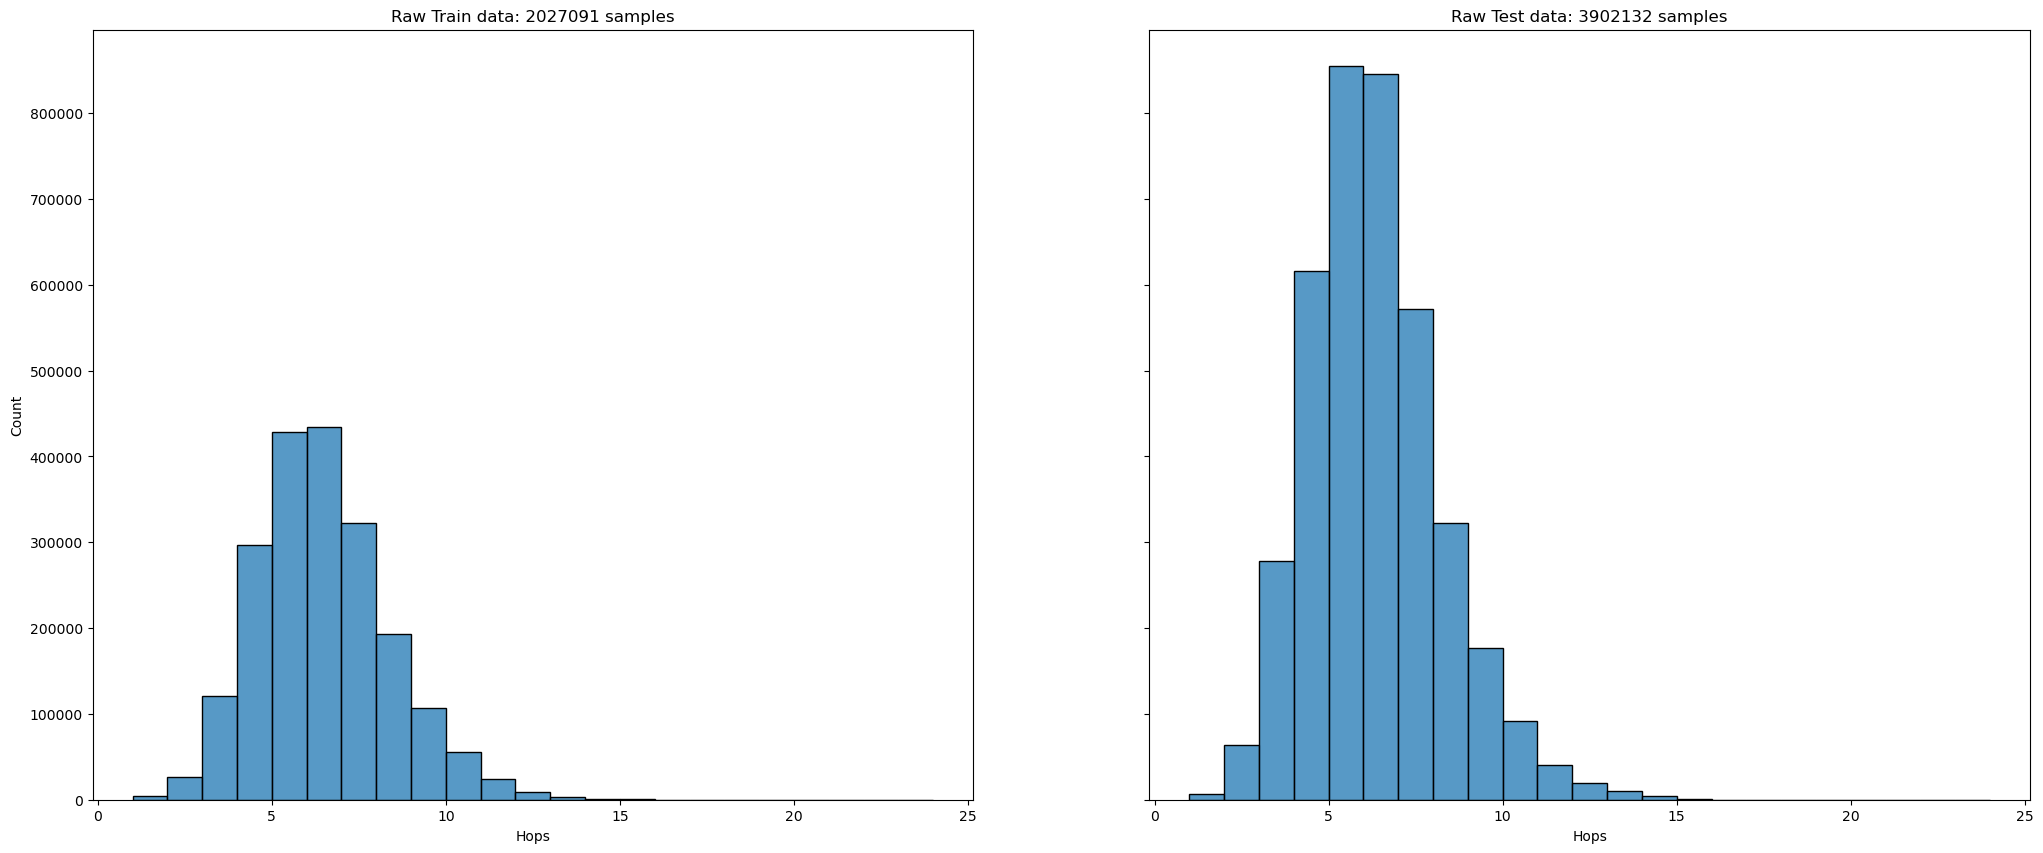

Balanced Train data: 58974 samples
Validation data: 5278 samples


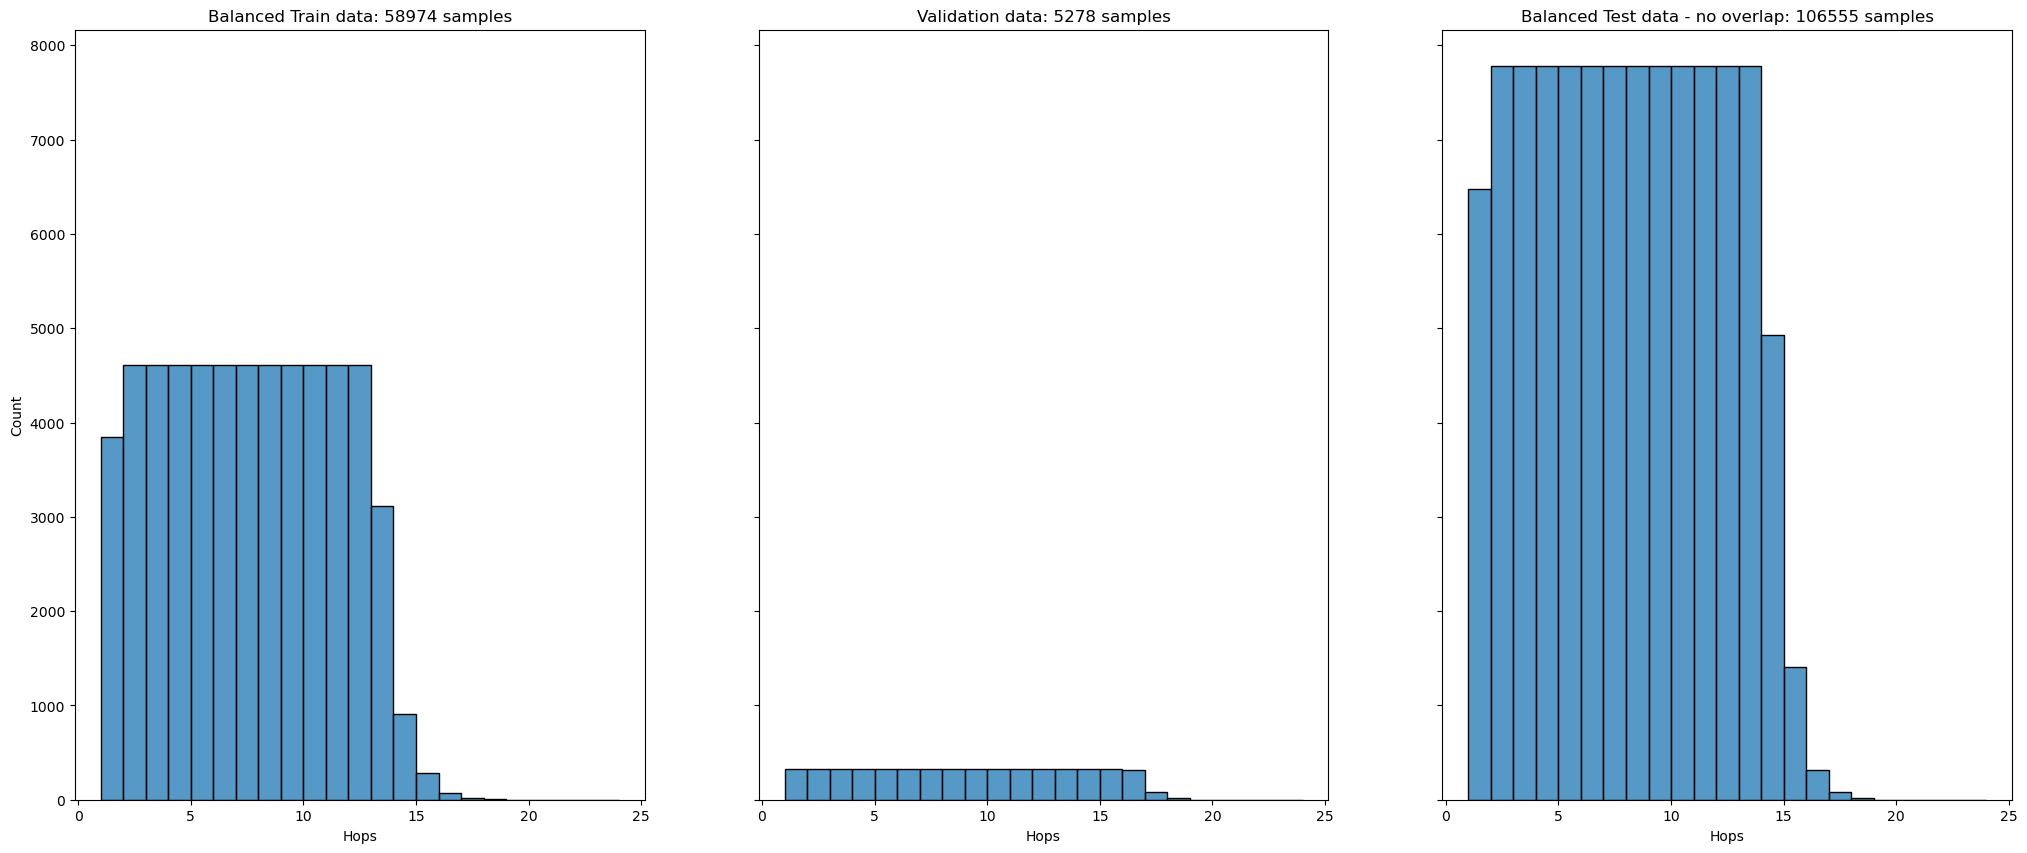

                                                      Head  \
73661                                              Ethanol   
259088                              SI, sucrase-isomaltase   
1614644                        ATG12, autophagy related 12   
1430233                  HRAS, HRas proto-oncogene, GTPase   
933598   PIK3CA, phosphatidylinositol-4,5-bisphosphate ...   
...                                                    ...   
831782       ALG10B, ALG10 alpha-1,2-glucosyltransferase B   
828681          MOGS, mannosyl-oligosaccharide glucosidase   
829643          MOGS, mannosyl-oligosaccharide glucosidase   
854291                       Dolichyl D-glucosyl phosphate   
832738       ALG10B, ALG10 alpha-1,2-glucosyltransferase B   

                                                      Tail      Hops  
73661    SLC29A1, solute carrier family 29 member 1 (Au...  1.000000  
259088                                           D-Glucose  1.000000  
1614644                        ATG10, auto

In [4]:
y_transform = inverse_transform
x_train,y_train,x_valid,y_valid,x_sub_train,y_sub_train,x_test_balanced,y_test_balanced = Load_Datasets(
     'v8',y_transform = y_transform, Max_Hops_Samples_relativeToHop1 = 1.2, ValidationPercentageSplit = 0.05, SubTrainPercentage = 0.05)

# Define Model Architecture

In [5]:
class PubMedBERT(nn.Module):
    def __init__(self, checkpoint = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"):
        super().__init__()
        self.weight_path = checkpoint
        self.bert = AutoModel.from_pretrained(self.weight_path)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(768, 1024), nn.ReLU(), nn.Dropout(0.2),
#             nn.Linear(2048, 2048), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(1024,512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 1)
            )

    def forward(self,input_ids, token_type_ids, attention_masks, return_dict=None):
        outputs = self.bert(input_ids, 
                            attention_mask=attention_masks,
                            token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        
        logits = self.linear_relu_stack(pooled_output)
        return logits
    
class tokenizer_input():
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
    def save_pretrained(path):
        self.tokenizer.save_pretrained(path)
        
    def __call__(self, inputs_list):
        inputs = []
        for row in inputs_list:
            X_ls = row.split(' [SEP] ')
            inputs.append([X_ls[0],X_ls[1]])
        encoding = self.tokenizer(list(inputs), return_tensors='pt', padding=True)
        input_ids = encoding['input_ids'].to(self.device)
        token_type_ids = encoding['token_type_ids'].to(self.device)
        attention_masks = encoding['attention_mask'].to(self.device)
        return [input_ids, token_type_ids, attention_masks]

# Hyper-parameters and Train

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1


  0%|          | 0/3686 [00:00<?, ?it/s]

Batch   500    Loss: 0.06577
Batch  1000    Loss: 0.03982
Batch  1500    Loss: 0.03344
Batch  2000    Loss: 0.03027
Batch  2500    Loss: 0.02729
Batch  3000    Loss: 0.02730
Batch  3500    Loss: 0.02656


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
		Loss: 0.021359
		Total Mean Squared Error: 0.0214
		Total Mean Absolute Error: 0.0811

 Hop '1'	MAE: 0.3672, MSE: 0.1798
 Hop '2'	MAE: 0.1748, MSE: 0.0415
 Hop '3'	MAE: 0.1245, MSE: 0.0270

Percentage of prediction > 0.5: 
 Hop  1: 	72.9167%
 Hops 2-3: 	28.3854%
 Hops 4-10: 	2.1577%
 Hops 11+: 	0.1907%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	81.8713%
Recall: 	72.9167%
Accuracy: 	96.7892%
f1: 		77.1350%
f1 Gain: 	97.4142%


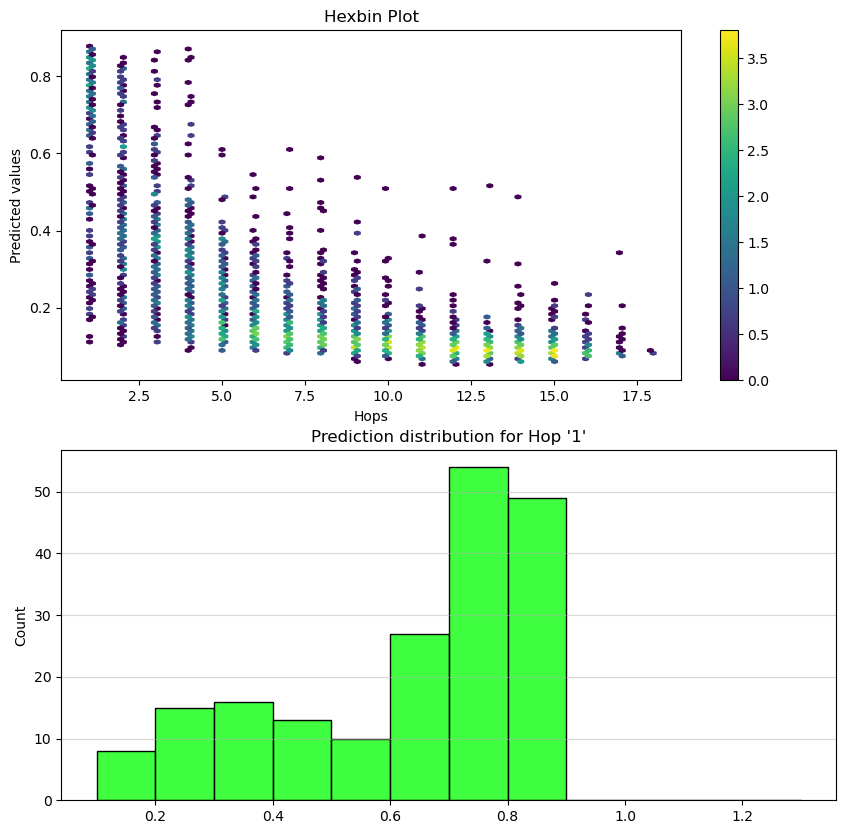

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
		Loss: 0.025437
		Total Mean Squared Error: 0.0254
		Total Mean Absolute Error: 0.0869

 Hop '1'	MAE: 0.4445, MSE: 0.2576
 Hop '2'	MAE: 0.1835, MSE: 0.0444
 Hop '3'	MAE: 0.1244, MSE: 0.0249

Percentage of prediction > 0.5: 
 Hop  1: 	59.2593%
 Hops 2-3: 	21.9136%
 Hops 4-10: 	1.6314%
 Hops 11+: 	0.1963%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	82.4034%
Recall: 	59.2593%
Accuracy: 	96.2635%
f1: 		68.9408%
f1 Gain: 	96.3343%


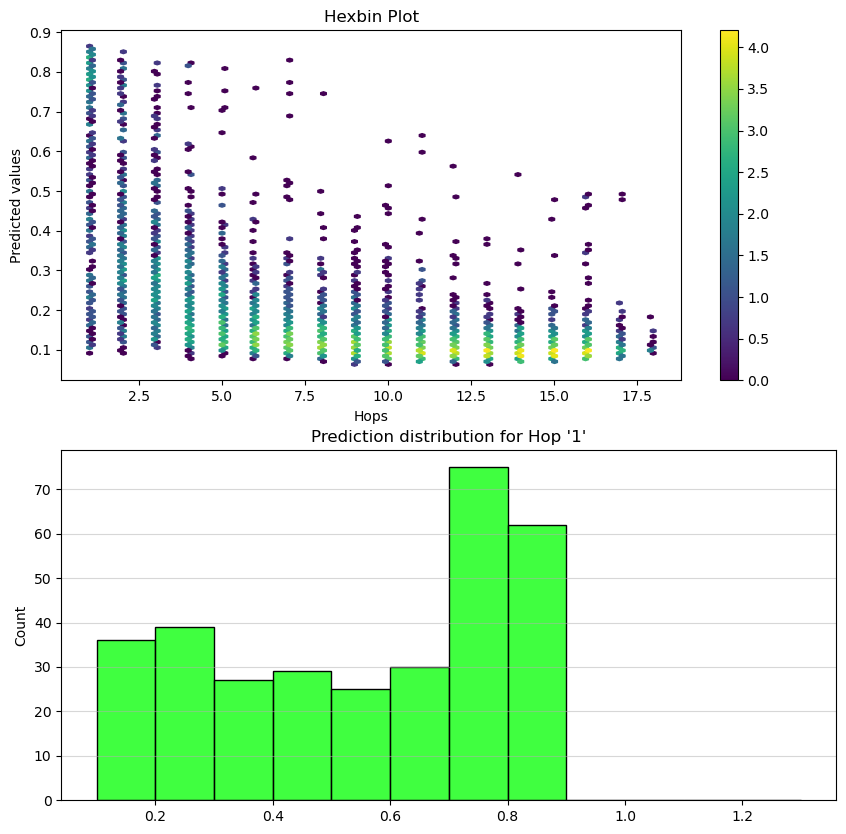

New best Validation! Saving weights...
Epoch 2


  0%|          | 0/3686 [00:00<?, ?it/s]

Batch   500    Loss: 0.02648
Batch  1000    Loss: 0.02529
Batch  1500    Loss: 0.02377
Batch  2000    Loss: 0.02451
Batch  2500    Loss: 0.02334
Batch  3000    Loss: 0.02368
Batch  3500    Loss: 0.02467


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
		Loss: 0.018852
		Total Mean Squared Error: 0.0189
		Total Mean Absolute Error: 0.0760

 Hop '1'	MAE: 0.2948, MSE: 0.1323
 Hop '2'	MAE: 0.1721, MSE: 0.0417
 Hop '3'	MAE: 0.1319, MSE: 0.0314

Percentage of prediction > 0.5: 
 Hop  1: 	79.6875%
 Hops 2-3: 	33.8542%
 Hops 4-10: 	2.8274%
 Hops 11+: 	0.0000%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	80.1047%
Recall: 	79.6875%
Accuracy: 	97.0213%
f1: 		79.8956%
f1 Gain: 	97.8049%


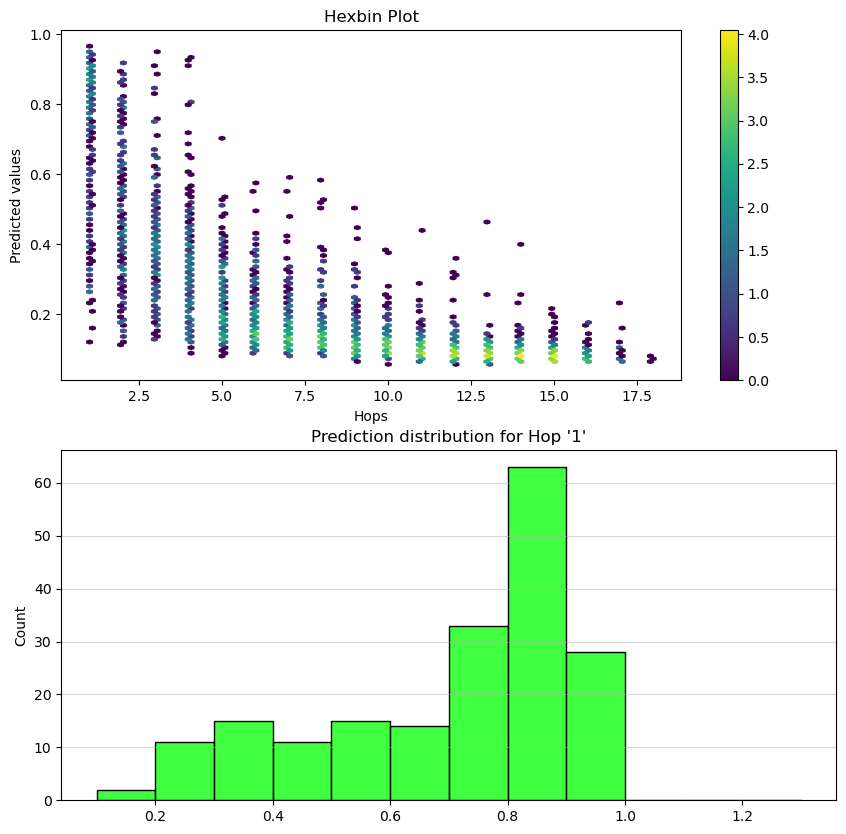

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
		Loss: 0.024612
		Total Mean Squared Error: 0.0246
		Total Mean Absolute Error: 0.0852

 Hop '1'	MAE: 0.3895, MSE: 0.2210
 Hop '2'	MAE: 0.1765, MSE: 0.0437
 Hop '3'	MAE: 0.1259, MSE: 0.0290

Percentage of prediction > 0.5: 
 Hop  1: 	61.4198%
 Hops 2-3: 	24.5370%
 Hops 4-10: 	2.0723%
 Hops 11+: 	0.6379%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	76.8340%
Recall: 	61.4198%
Accuracy: 	96.0043%
f1: 		68.2676%
f1 Gain: 	96.2179%


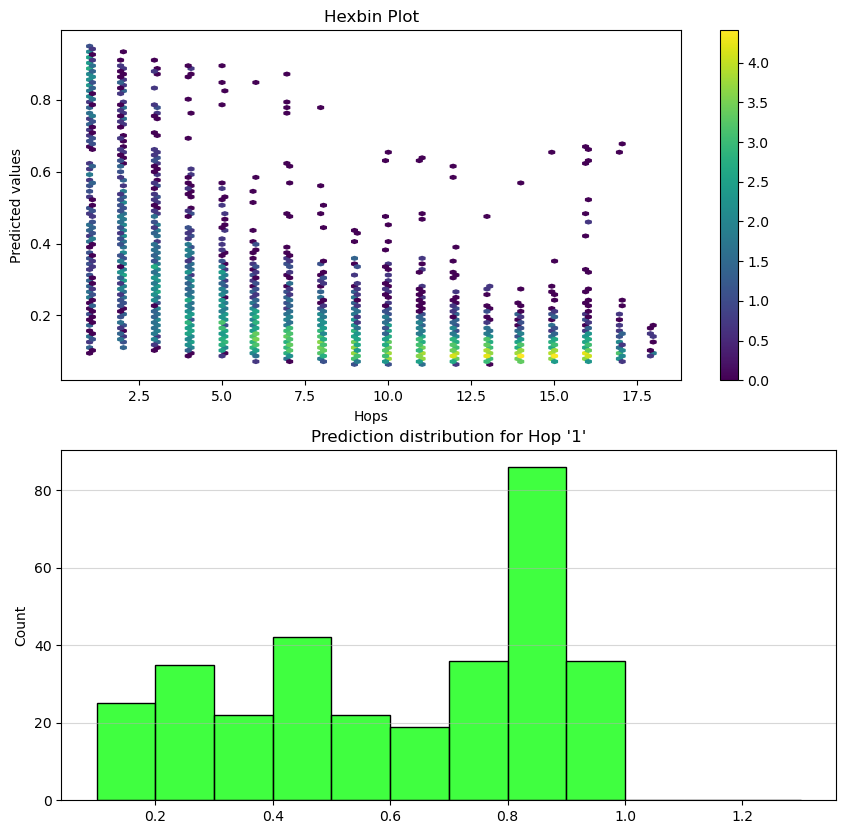

Epoch 3


  0%|          | 0/3686 [00:00<?, ?it/s]

Batch   500    Loss: 0.02326
Batch  1000    Loss: 0.02245
Batch  1500    Loss: 0.02139
Batch  2000    Loss: 0.02098
Batch  2500    Loss: 0.02289
Batch  3000    Loss: 0.02310
Batch  3500    Loss: 0.02224


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
		Loss: 0.016908
		Total Mean Squared Error: 0.0169
		Total Mean Absolute Error: 0.0685

 Hop '1'	MAE: 0.2572, MSE: 0.1153
 Hop '2'	MAE: 0.1775, MSE: 0.0441
 Hop '3'	MAE: 0.1252, MSE: 0.0304

Percentage of prediction > 0.5: 
 Hop  1: 	81.7708%
 Hops 2-3: 	33.0729%
 Hops 4-10: 	1.7113%
 Hops 11+: 	0.0000%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	87.2222%
Recall: 	81.7708%
Accuracy: 	97.7563%
f1: 		84.4086%
f1 Gain: 	98.3887%


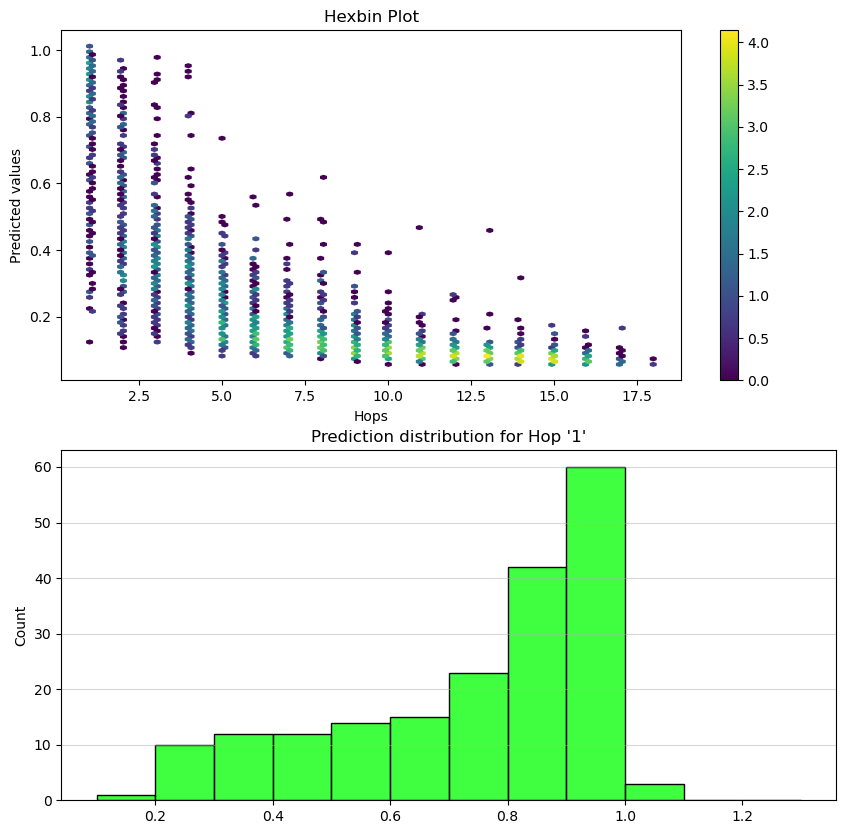

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
		Loss: 0.024829
		Total Mean Squared Error: 0.0248
		Total Mean Absolute Error: 0.0833

 Hop '1'	MAE: 0.3686, MSE: 0.2150
 Hop '2'	MAE: 0.1852, MSE: 0.0482
 Hop '3'	MAE: 0.1268, MSE: 0.0300

Percentage of prediction > 0.5: 
 Hop  1: 	62.9630%
 Hops 2-3: 	21.9136%
 Hops 4-10: 	2.1164%
 Hops 11+: 	0.8342%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	75.8364%
Recall: 	62.9630%
Accuracy: 	96.0043%
f1: 		68.8027%
f1 Gain: 	96.3106%


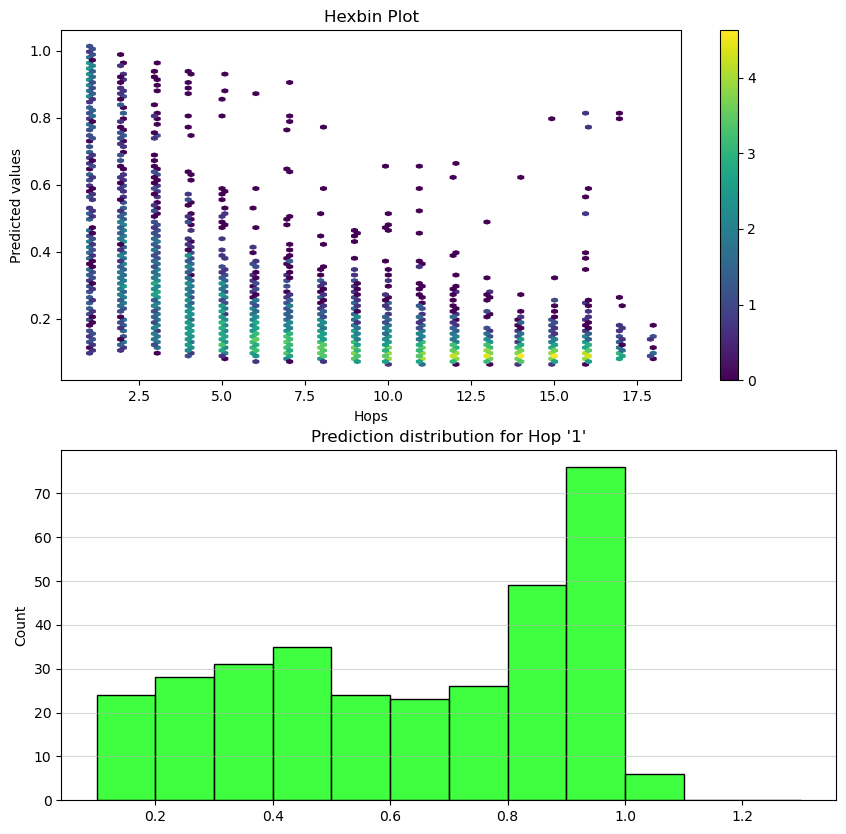

Epoch 4


  0%|          | 0/3686 [00:00<?, ?it/s]

Batch   500    Loss: 0.02030
Batch  1000    Loss: 0.02196
Batch  1500    Loss: 0.02056
Batch  2000    Loss: 0.02132
Batch  2500    Loss: 0.01936
Batch  3000    Loss: 0.02026
Batch  3500    Loss: 0.02104


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
		Loss: 0.015657
		Total Mean Squared Error: 0.0157
		Total Mean Absolute Error: 0.0658

 Hop '1'	MAE: 0.2249, MSE: 0.0948
 Hop '2'	MAE: 0.1763, MSE: 0.0440
 Hop '3'	MAE: 0.1279, MSE: 0.0321

Percentage of prediction > 0.5: 
 Hop  1: 	86.4583%
 Hops 2-3: 	35.6771%
 Hops 4-10: 	1.9345%
 Hops 11+: 	0.0000%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	86.4583%
Recall: 	86.4583%
Accuracy: 	97.9884%
f1: 		86.4583%
f1 Gain: 	98.6337%


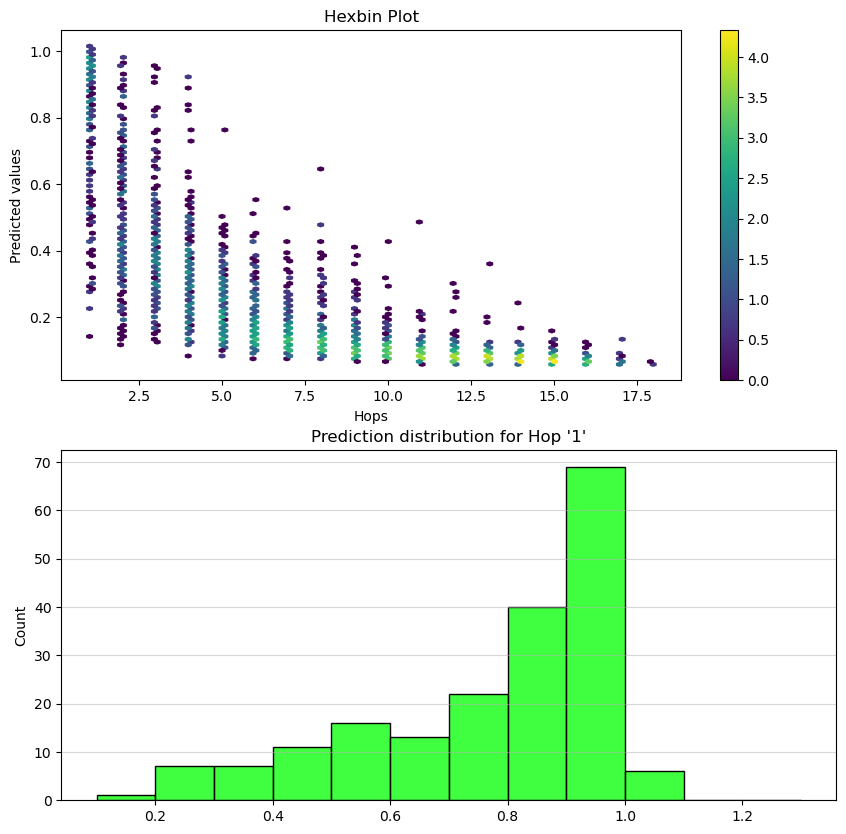

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
		Loss: 0.024857
		Total Mean Squared Error: 0.0249
		Total Mean Absolute Error: 0.0835

 Hop '1'	MAE: 0.3487, MSE: 0.2009
 Hop '2'	MAE: 0.1856, MSE: 0.0484
 Hop '3'	MAE: 0.1290, MSE: 0.0318

Percentage of prediction > 0.5: 
 Hop  1: 	63.8889%
 Hops 2-3: 	23.6111%
 Hops 4-10: 	2.3810%
 Hops 11+: 	0.9323%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	73.9286%
Recall: 	63.8889%
Accuracy: 	95.8963%
f1: 		68.5430%
f1 Gain: 	96.2658%


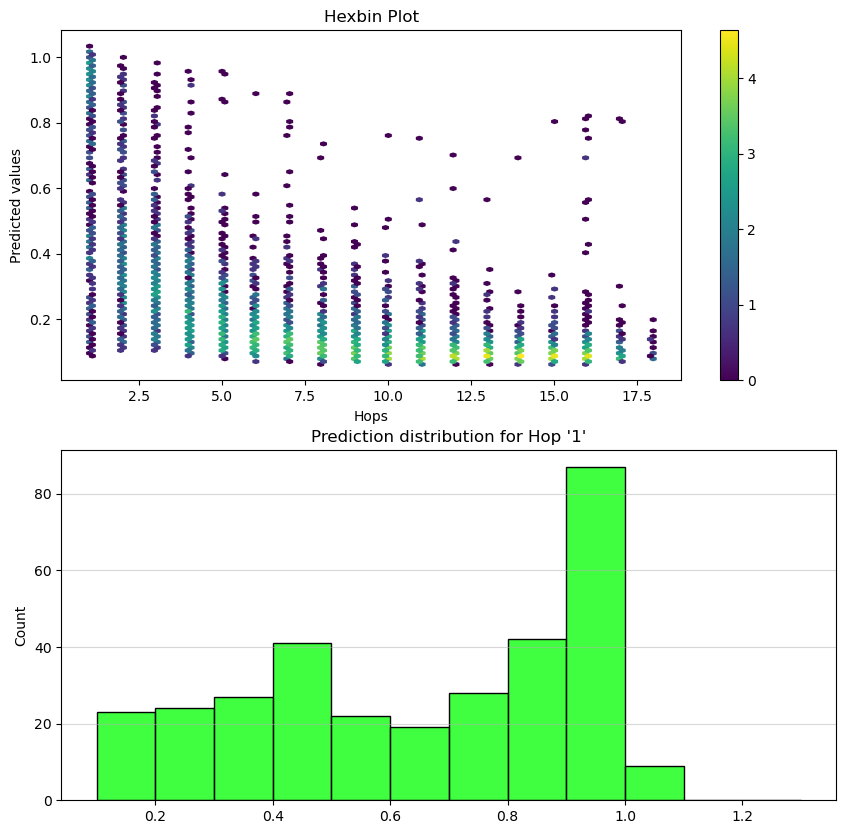

Epoch 5


  0%|          | 0/3686 [00:00<?, ?it/s]

Batch   500    Loss: 0.02012
Batch  1000    Loss: 0.01806
Batch  1500    Loss: 0.01920
Batch  2000    Loss: 0.02014
Batch  2500    Loss: 0.01940
Batch  3000    Loss: 0.01934
Batch  3500    Loss: 0.01931


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
		Loss: 0.014375
		Total Mean Squared Error: 0.0144
		Total Mean Absolute Error: 0.0625

 Hop '1'	MAE: 0.1984, MSE: 0.0787
 Hop '2'	MAE: 0.1727, MSE: 0.0438
 Hop '3'	MAE: 0.1393, MSE: 0.0353

Percentage of prediction > 0.5: 
 Hop  1: 	88.5417%
 Hops 2-3: 	38.5417%
 Hops 4-10: 	2.3065%
 Hops 11+: 	0.0000%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	84.5771%
Recall: 	88.5417%
Accuracy: 	97.9497%
f1: 		86.5140%
f1 Gain: 	98.6402%


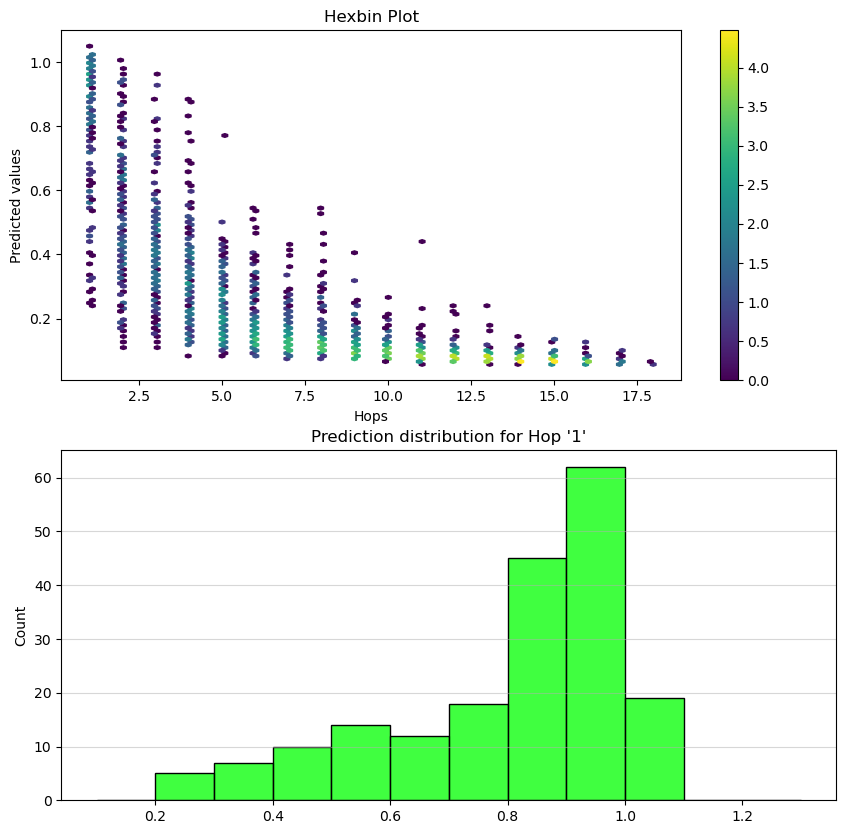

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
		Loss: 0.025128
		Total Mean Squared Error: 0.0251
		Total Mean Absolute Error: 0.0836

 Hop '1'	MAE: 0.3434, MSE: 0.2014
 Hop '2'	MAE: 0.1844, MSE: 0.0489
 Hop '3'	MAE: 0.1346, MSE: 0.0338

Percentage of prediction > 0.5: 
 Hop  1: 	66.6667%
 Hops 2-3: 	26.5432%
 Hops 4-10: 	2.2046%
 Hops 11+: 	0.9814%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	75.5245%
Recall: 	66.6667%
Accuracy: 	96.1555%
f1: 		70.8197%
f1 Gain: 	96.6474%


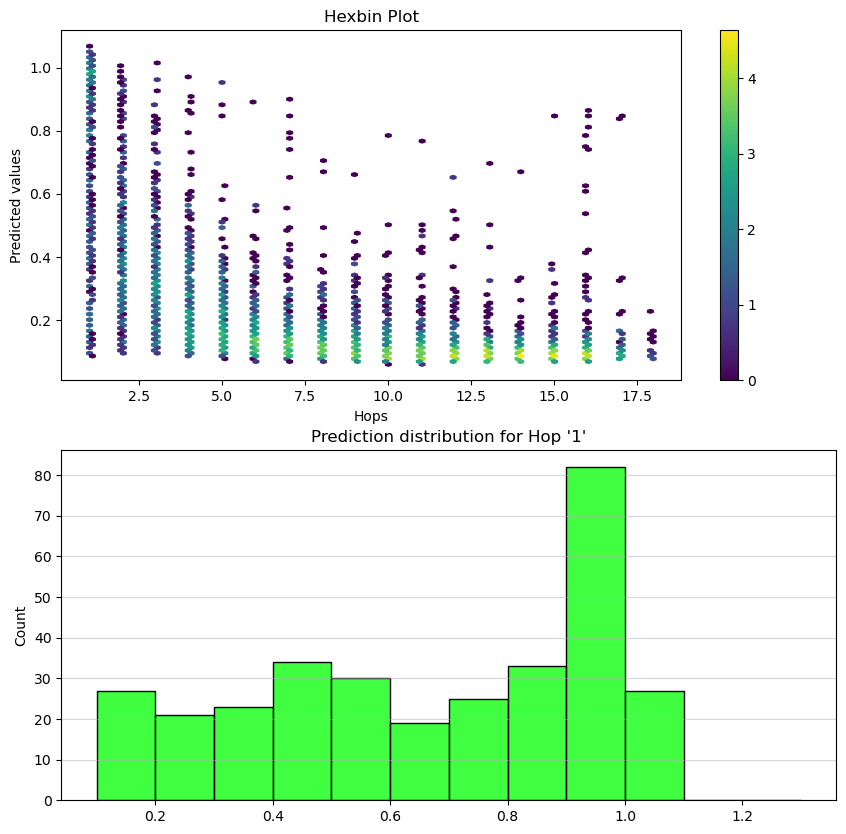

New best Validation! Saving weights...
Epoch 6


  0%|          | 0/3686 [00:00<?, ?it/s]

Batch   500    Loss: 0.01805
Batch  1000    Loss: 0.01807
Batch  1500    Loss: 0.01856
Batch  2000    Loss: 0.01702
Batch  2500    Loss: 0.01893
Batch  3000    Loss: 0.01770
Batch  3500    Loss: 0.01888


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
		Loss: 0.012595
		Total Mean Squared Error: 0.0126
		Total Mean Absolute Error: 0.0578

 Hop '1'	MAE: 0.1978, MSE: 0.0770
 Hop '2'	MAE: 0.1691, MSE: 0.0416
 Hop '3'	MAE: 0.1230, MSE: 0.0293

Percentage of prediction > 0.5: 
 Hop  1: 	88.5417%
 Hops 2-3: 	34.1146%
 Hops 4-10: 	1.5625%
 Hops 11+: 	0.0000%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	89.0052%
Recall: 	88.5417%
Accuracy: 	98.3366%
f1: 		88.7728%
f1 Gain: 	98.8968%


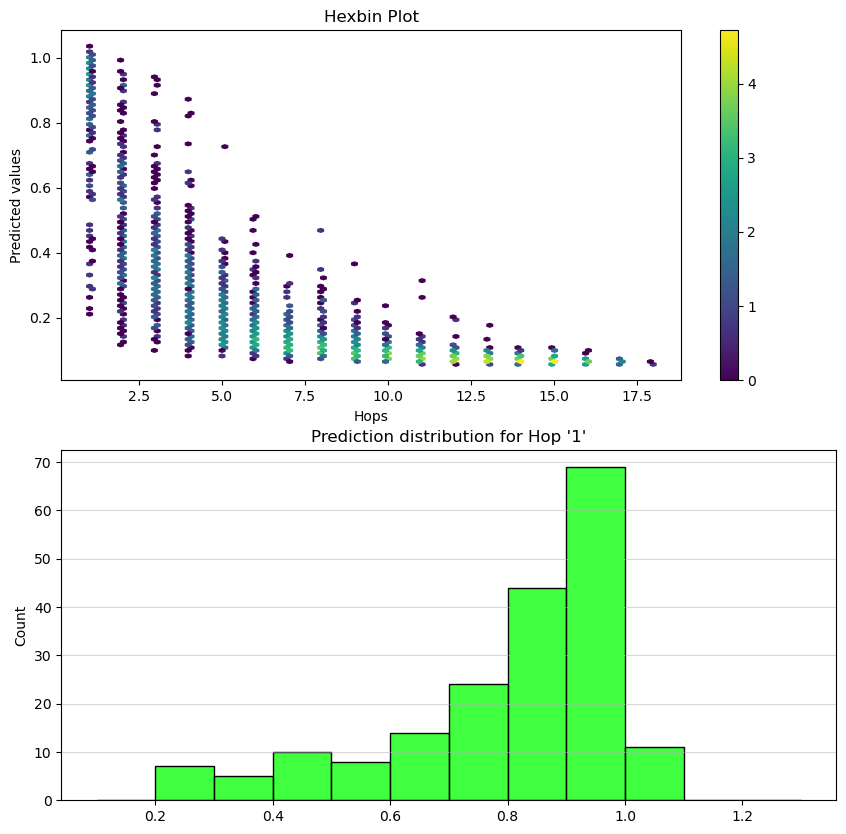

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
		Loss: 0.025330
		Total Mean Squared Error: 0.0253
		Total Mean Absolute Error: 0.0814

 Hop '1'	MAE: 0.3597, MSE: 0.2166
 Hop '2'	MAE: 0.1990, MSE: 0.0539
 Hop '3'	MAE: 0.1356, MSE: 0.0321

Percentage of prediction > 0.5: 
 Hop  1: 	62.6543%
 Hops 2-3: 	22.9938%
 Hops 4-10: 	1.9841%
 Hops 11+: 	0.9814%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	75.7463%
Recall: 	62.6543%
Accuracy: 	95.9827%
f1: 		68.5811%
f1 Gain: 	96.2724%


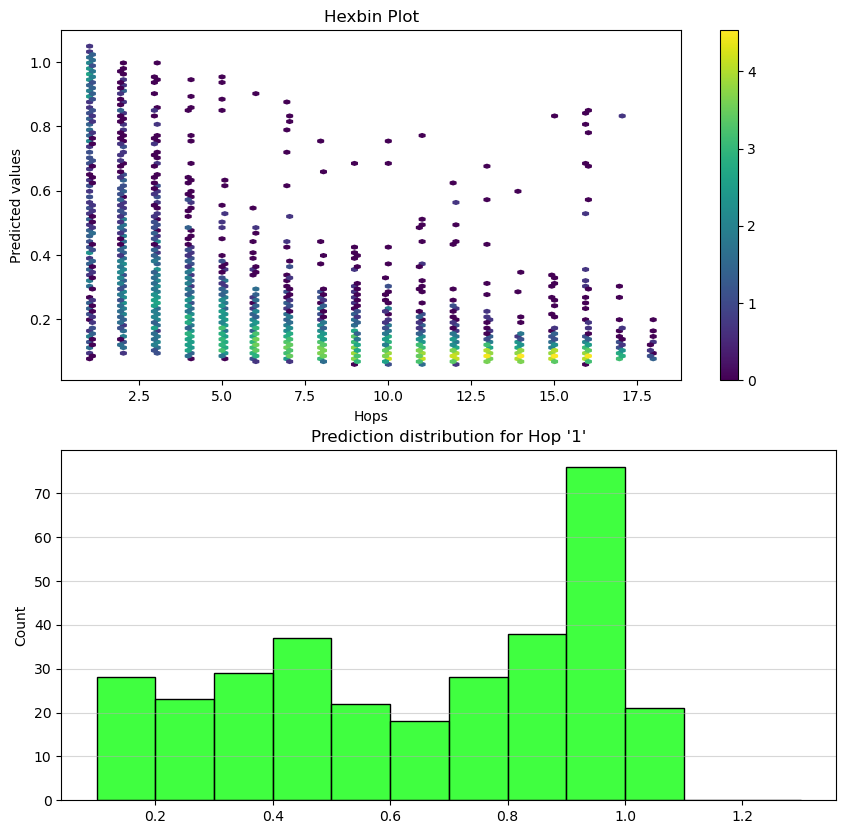

Epoch 7


  0%|          | 0/3686 [00:00<?, ?it/s]

Batch   500    Loss: 0.01779
Batch  1000    Loss: 0.01617
Batch  1500    Loss: 0.01705
Batch  2000    Loss: 0.01781
Batch  2500    Loss: 0.01654
Batch  3000    Loss: 0.01862
Batch  3500    Loss: 0.01709


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
		Loss: 0.011375
		Total Mean Squared Error: 0.0114
		Total Mean Absolute Error: 0.0540

 Hop '1'	MAE: 0.2017, MSE: 0.0781
 Hop '2'	MAE: 0.1592, MSE: 0.0378
 Hop '3'	MAE: 0.1110, MSE: 0.0243

Percentage of prediction > 0.5: 
 Hop  1: 	88.5417%
 Hops 2-3: 	28.9062%
 Hops 4-10: 	1.0417%
 Hops 11+: 	0.0000%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	92.3913%
Recall: 	88.5417%
Accuracy: 	98.6074%
f1: 		90.4255%
f1 Gain: 	99.0764%


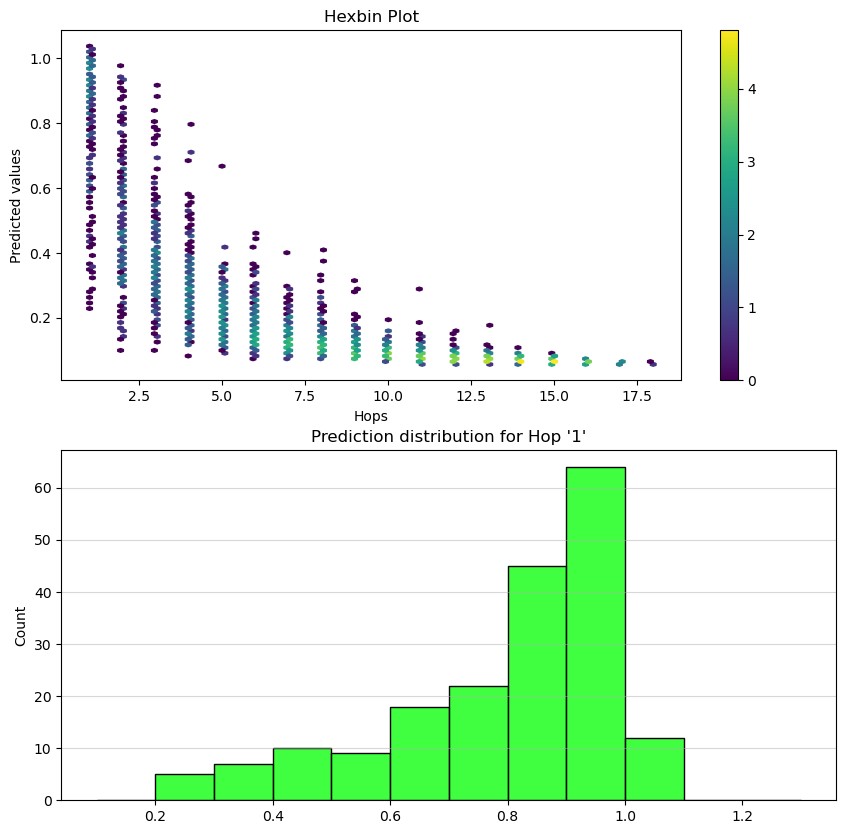

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
		Loss: 0.025184
		Total Mean Squared Error: 0.0252
		Total Mean Absolute Error: 0.0812

 Hop '1'	MAE: 0.3691, MSE: 0.2251
 Hop '2'	MAE: 0.1981, MSE: 0.0533
 Hop '3'	MAE: 0.1259, MSE: 0.0278

Percentage of prediction > 0.5: 
 Hop  1: 	60.8025%
 Hops 2-3: 	19.4444%
 Hops 4-10: 	1.7637%
 Hops 11+: 	0.7360%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	78.1746%
Recall: 	60.8025%
Accuracy: 	96.0691%
f1: 		68.4028%
f1 Gain: 	96.2415%


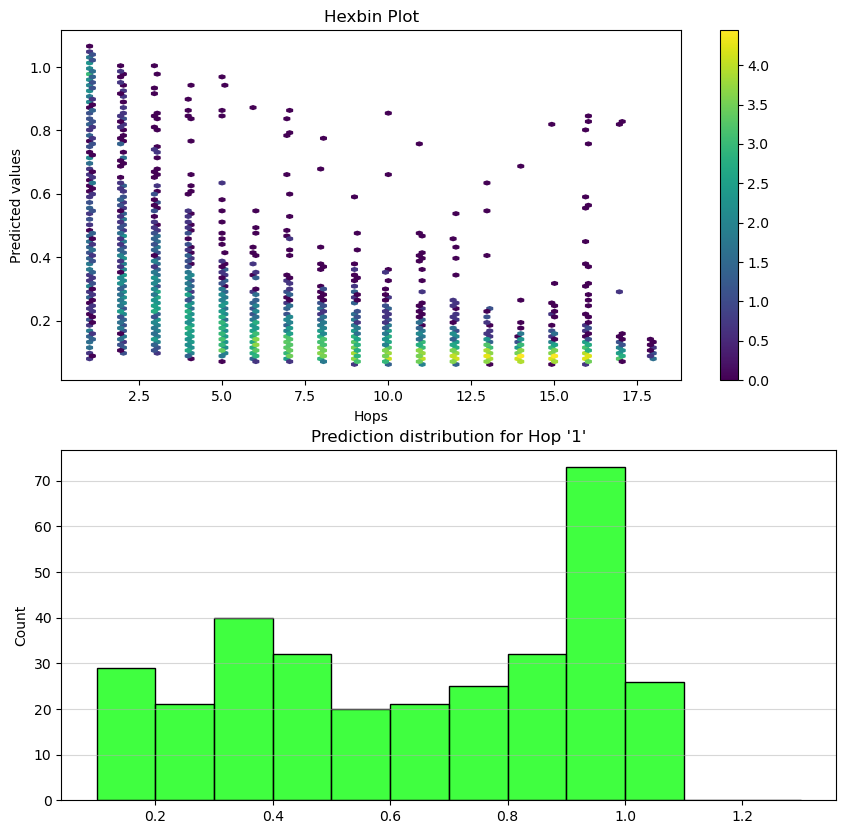

Finished Training


In [6]:
from torchmetrics import MeanAbsolutePercentageError

# Custom loss function
def my_loss(output, target):
    loss = torch.mean(((output - target)**2)) # MSE
#     loss = torch.mean(((output - target)**2)*(target+0.05/target)) # More attention to low hops
    return loss

def save_for_best_loss(metrics):
    return 1/metrics["pseudo_f1"]

# Hyper parameters
epochs = 7
LR = 1e-6
BSZ = 16
criterion = my_loss
# criterion = MeanAbsolutePercentageError().to('cuda')

#Initialize model and tokenizer
checkpoint = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
model = PubMedBERT(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
token_input = tokenizer_input(tokenizer)
optimizer = optim.Adam(model.parameters(), lr=LR)
# print(model)

# Data Loaders
train_loader = DataLoader(tuple(zip(x_train,y_train)), batch_size=BSZ, shuffle=True)
sub_train_loader = DataLoader(tuple(zip(x_sub_train,y_sub_train)), batch_size=1, shuffle=True)
valid_loader = DataLoader(tuple(zip(x_valid,y_valid)), batch_size=1, shuffle=True)

# Train and Test(sub-test)
_,stopping_epoch = AIO(model, token_input, train_loader, valid_loader, epochs, criterion, optimizer,'PubMedBERT', save_criterion_func = save_for_best_loss, train_loader2 = sub_train_loader)

# Final Tests

Test trained model on balanced test set - no common nodes with train


  0%|          | 0/106555 [00:00<?, ?it/s]


Test Results:
		Loss: 0.024820
		Total Mean Squared Error: 0.0248
		Total Mean Absolute Error: 0.0865

 Hop '1'	MAE: 0.3478, MSE: 0.1922
 Hop '2'	MAE: 0.1911, MSE: 0.0514
 Hop '3'	MAE: 0.1327, MSE: 0.0312

Percentage of prediction > 0.5: 
 Hop  1: 	67.6439%
 Hops 2-3: 	25.3440%
 Hops 4-10: 	2.4633%
 Hops 11+: 	0.6748%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	73.9541%
Recall: 	67.6439%
Accuracy: 	95.9989%
f1: 		70.6584%
f1 Gain: 	96.5513%


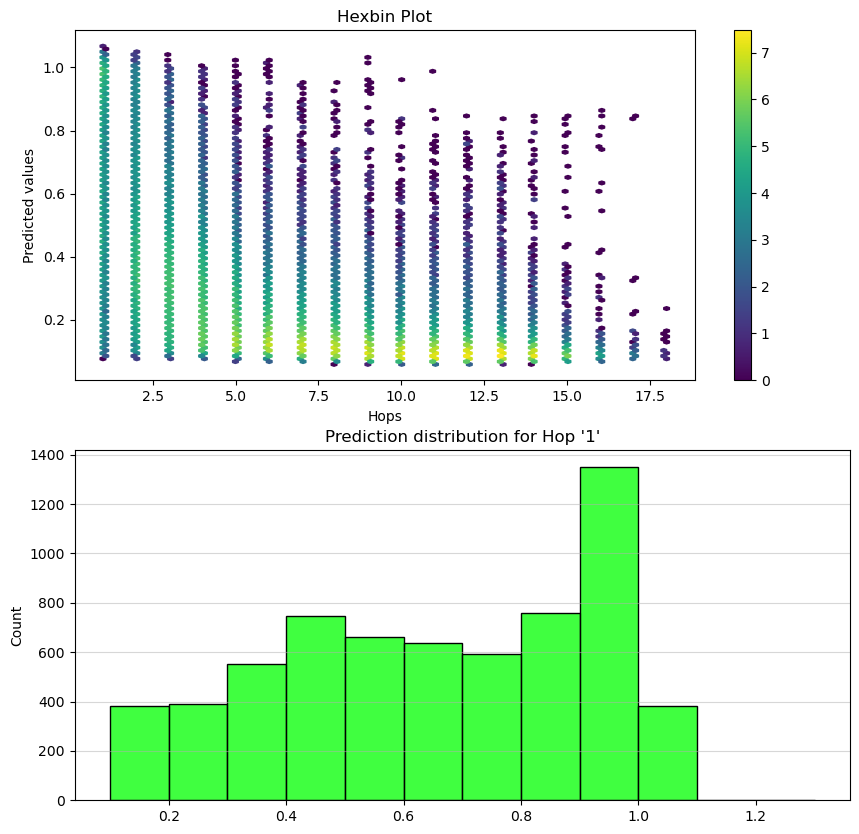

In [7]:
# Loader for final testing (balanced)
test_balanced_loader = DataLoader(tuple(zip(x_test_balanced,y_test_balanced)), batch_size=1, shuffle=True)

# Load Best version for testing
model_PMB = torch.load("./PubMedBERT/Model.pth")#, map_location=torch.device('cpu'))
model_PMB.eval()
print("Test trained model on balanced test set - no common nodes with train")
balanced_test_metrics = test_model(model_PMB, token_input, test_balanced_loader, criterion)

Test model on all original train data


  0%|          | 0/58974 [00:00<?, ?it/s]


Test Results:
		Loss: 0.016785
		Total Mean Squared Error: 0.0168
		Total Mean Absolute Error: 0.0704

 Hop '1'	MAE: 0.2174, MSE: 0.0931
 Hop '2'	MAE: 0.1722, MSE: 0.0455
 Hop '3'	MAE: 0.1351, MSE: 0.0331

Percentage of prediction > 0.5: 
 Hop  1: 	86.3944%
 Hops 2-3: 	41.1121%
 Hops 4-10: 	1.8860%
 Hops 11+: 	0.0367%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	84.3964%
Recall: 	86.3944%
Accuracy: 	97.7145%
f1: 		85.3837%
f1 Gain: 	98.4355%


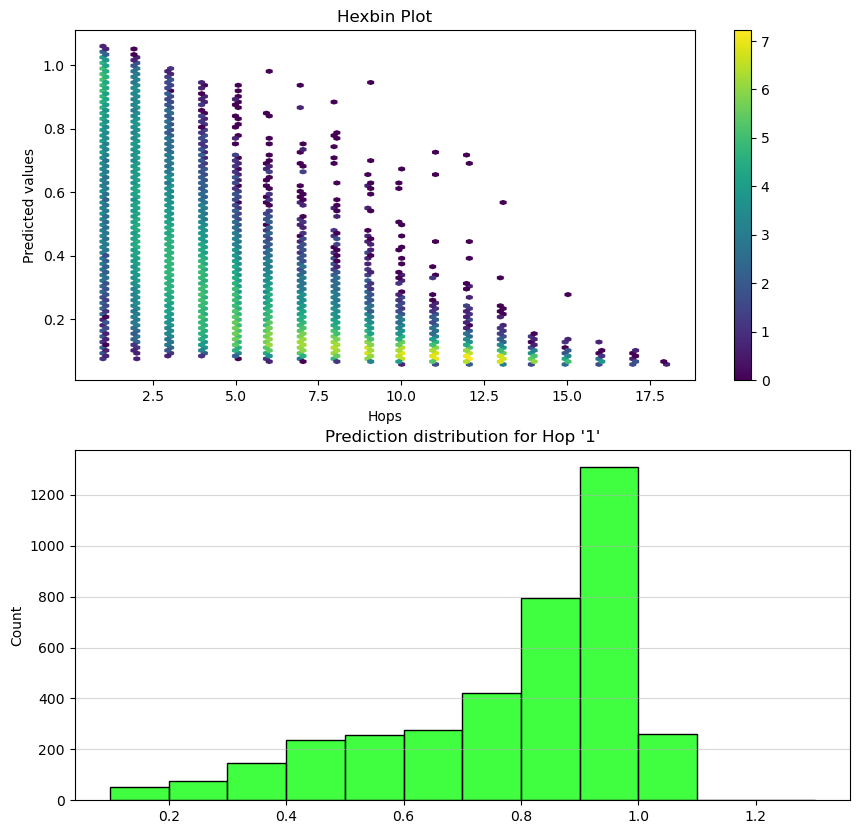

In [8]:
print("Test model on all original train data")
train_loader_for_testing = DataLoader(tuple(zip(x_train,y_train)), batch_size=1, shuffle=True)
balanced_train_metrics = test_model(model_PMB, token_input, train_loader_for_testing, criterion)

In [9]:
# print("Test model on all distant pairs") 
# data_dis = pd.read_csv('/kaggle/input/biobert-tutorial/Distant pairs Undirected.csv', header=0)
# data_dis = data_dis[data_dis["Hops"]>11] # >11 to reduce time

# data_dis["Hops"] = y_transform(data_dis["Hops"])
# y_test_dis = pd.to_numeric(data_dis.Hops)#.astype(int)
# x_test_dis = np.vectorize(joining)(data_dis.Head.astype(str),data_dis.Tail.astype(str))

# distant_loader = DataLoader(tuple(zip(x_test_dis,y_test_dis)), batch_size=1, shuffle=True)
# distant_pairs_metrics = test_model(model_PMB, token_input, distant_loader, criterion)

In [10]:
# temp = pd.DataFrame([last_epoch, balanced_test_metrics, balanced_train_metrics, distant_pairs_metrics])
# temp.to_csv('testout.csv')